<a href="https://colab.research.google.com/github/SophiaAlencar/LH_CD_SOPHIAALENCAR/blob/main/desafio_indi_Predict_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OBJETIVO: Modelo de Predição

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVRDataFrame

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [73]:
DataFrame.head(10)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0
5,Pulp Fiction,1994,A,154,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762.0
6,Schindler's List,1993,A,195,"Biography, Drama, History",8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1213505,96898818.0
7,Inception,2010,UA,148,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195.0
8,Fight Club,1999,A,139,Drama,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0
9,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,"Action, Adventure, Drama",8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750.0


## TRATAMENTO REALIZADO NO EDA

In [74]:
DataFrame = DataFrame.drop(columns=['Unnamed: 0'])
DataFrame = DataFrame[DataFrame['Released_Year'] != 'PG']
DataFrame['Released_Year'] = DataFrame['Released_Year'].astype(int)
DataFrame['Runtime'] = DataFrame['Runtime'].str.replace(' min', '', regex=False).astype(int)
DataFrame['Meta_score'] = DataFrame['Meta_score'].fillna(0)
DataFrame['Certificate'] = DataFrame['Certificate'].fillna('Unrated')
DataFrame['Gross'] = DataFrame['Gross'].str.replace(',', '', regex=False)
DataFrame['Gross'] = DataFrame['Gross'].astype(float)
mean_gross = DataFrame['Gross'].mean()
DataFrame['Gross'] = DataFrame['Gross'].fillna(mean_gross)

KeyError: "['Unnamed: 0'] not found in axis"

## MODELING

In [76]:
DataFrame_processed = DataFrame.copy()
DataFrame_processed['Released_Year'] = pd.to_numeric(DataFrame_processed['Released_Year'], errors='coerce')#year column as numeric

#textfeatures
DataFrame_processed['Overview_Length'] = DataFrame_processed['Overview'].str.len()
DataFrame_processed['Overview_Word_Count'] = DataFrame_processed['Overview'].str.split().str.len()

#feature for genres
DataFrame_processed['Number_of_Genres'] = DataFrame_processed['Genre'].str.split(',').str.len()

#coding categorical variables
categorical_cols = ['Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']

#label para as categorias
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    DataFrame_processed[col + '_encoded'] = le.fit_transform(DataFrame_processed[col].astype(str))
    label_encoders[col] = le

#variables
feature_cols = [
    'Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross',
    'Overview_Length', 'Overview_Word_Count', 'Number_of_Genres'
] + [col + '_encoded' for col in categorical_cols]

target_col = 'IMDB_Rating'

#remove rows > null values
DataFrame_processed = DataFrame_processed.dropna(subset=feature_cols + [target_col])


In [77]:
#separate features and targets
X = DataFrame_processed[feature_cols]
y = DataFrame_processed[target_col]

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"training: {X_train.shape}, test: {X_test.shape}")

training: (798, 14), test: (200, 14)


RandomForest:
  RMSE: 0.2059
  MAE: 0.1545
  R²: 0.3558
----------------------------------------
GradientBoosting:
  RMSE: 0.1985
  MAE: 0.1512
  R²: 0.4015
----------------------------------------
LinearRegression:
  RMSE: 0.2101
  MAE: 0.1600
  R²: 0.3295
----------------------------------------
Ridge:
  RMSE: 0.2101
  MAE: 0.1600
  R²: 0.3296
----------------------------------------
Lasso:
  RMSE: 0.2484
  MAE: 0.2059
  R²: 0.0623
----------------------------------------

Best model: GradientBoosting


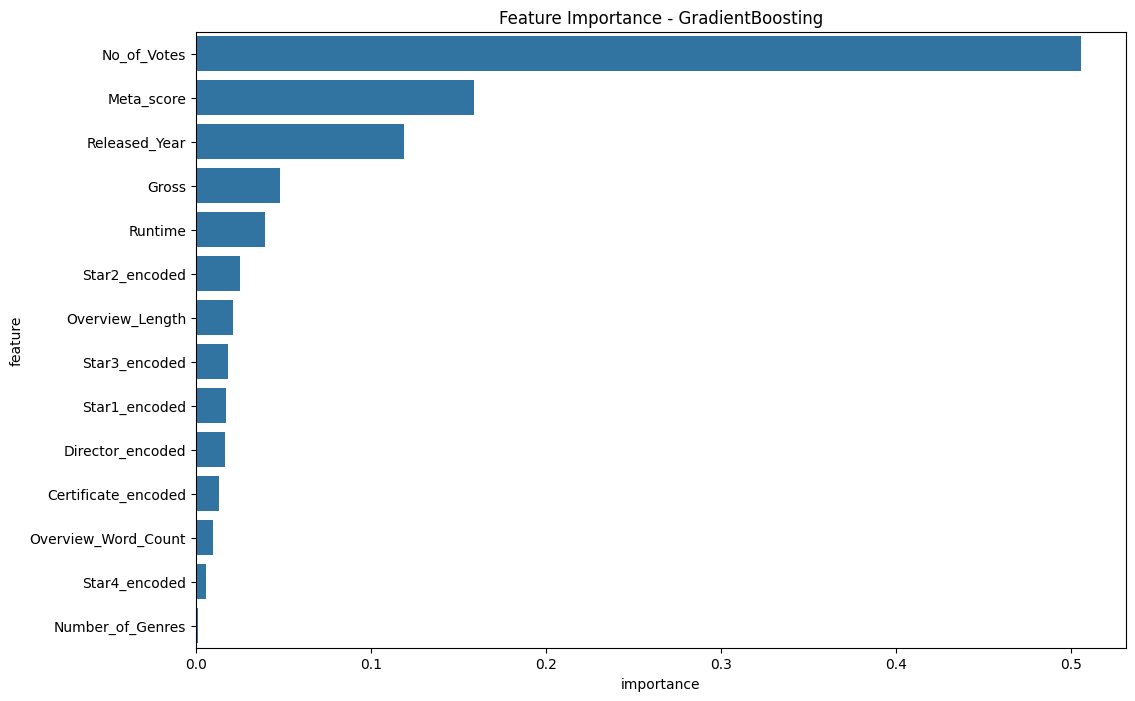

In [78]:
#models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}

#train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 40)

#choose the best model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

#feature importance of the best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()

In [79]:
#optimize hyperparameters of the best model
optimized_model = best_model

if best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print(f"Melhores parâmetros: {best_params}")

   #use the optimized model
    optimized_model = grid_search.best_estimator_

elif best_model_name == 'GradientBoosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5]
    }

    grid_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    optimized_model = grid_search.best_estimator_

elif best_model_name in ['Ridge', 'Lasso']:
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    }

    if best_model_name == 'Ridge':
        model_class = Ridge
    else:
        model_class = Lasso

    grid_search = GridSearchCV(
        model_class(random_state=42),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    print(f"Melhores parâmetros: {best_params}")

    optimized_model = grid_search.best_estimator_

#cross validation
cv_scores = cross_val_score(optimized_model, X_train_scaled, y_train,
                           cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"Average RMSE in cross-validation: {cv_rmse:.4f}")

#evaluation on the test set
y_pred_final = optimized_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print(f"\n Final Test Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Average RMSE in cross-validation: 0.1858

 Final Test Performance:
RMSE: 0.2019
R²: 0.3806


In [80]:
#dvanced features
DataFrame_enhanced = DataFrame.copy()
DataFrame_enhanced['Released_Year'] = pd.to_numeric(DataFrame_enhanced['Released_Year'], errors='coerce')
DataFrame_enhanced['Overview_Length'] = DataFrame_enhanced['Overview'].str.len()
DataFrame_enhanced['Overview_Word_Count'] = DataFrame_enhanced['Overview'].str.split().str.len()
genres = set()
for genre_list in DataFrame_enhanced['Genre'].str.split(','):
    genres.update([g.strip() for g in genre_list])

for genre in genres:
    DataFrame_enhanced[f'Genre_{genre}'] = DataFrame_enhanced['Genre'].str.contains(genre).astype(int)

current_year = 2024
DataFrame_enhanced['Movie_Age'] = current_year - DataFrame_enhanced['Released_Year']

DataFrame_enhanced['Votes_per_Year'] = DataFrame_enhanced['No_of_Votes'] / (current_year - DataFrame_enhanced['Released_Year'] + 1)
DataFrame_enhanced['Gross_per_Vote'] = DataFrame_enhanced['Gross'] / DataFrame_enhanced['No_of_Votes'].replace(0, 1)

#encode director and stars frequently (more informative than label encoding)
def frequency_encoding(series):
    return series.map(series.value_counts(normalize=True))

for col in ['Director', 'Star1', 'Star2', 'Star3', 'Star4']:
    DataFrame_enhanced[col + '_freq'] = frequency_encoding(DataFrame_enhanced[col])

#most promising features
enhanced_features = [
    'Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross',
    'Overview_Length', 'Overview_Word_Count', 'Movie_Age',
    'Votes_per_Year', 'Gross_per_Vote',
    'Director_freq', 'Star1_freq', 'Star2_freq', 'Star3_freq', 'Star4_freq'
] + [f'Genre_{genre}' for genre in list(genres)[:10]]  # Top 10 gêneros


df_enhanced = DataFrame_enhanced.dropna(subset=enhanced_features + ['IMDB_Rating'])
X_enhanced = df_enhanced[enhanced_features]
y_enhanced = df_enhanced['IMDB_Rating']

print(f":New shape {X_enhanced.shape}")

:New shape (998, 25)


In [81]:
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, shuffle=True
)

#scaling
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

#more powerful models
enhanced_models = {
    'XGBoost': XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=200),
    'SVR': SVR(kernel='rbf', C=10, gamma='scale')
}

#test
enhanced_results = {}
for name, model in enhanced_models.items():
    model.fit(X_train_enh_scaled, y_train_enh)
    y_pred = model.predict(X_test_enh_scaled)

    mse = mean_squared_error(y_test_enh, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_enh, y_pred)
    r2 = r2_score(y_test_enh, y_pred)

    enhanced_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

#find best model
best_enhanced_model_name = min(enhanced_results, key=lambda x: enhanced_results[x]['RMSE'])
best_enhanced_model = enhanced_models[best_enhanced_model_name]
print(f"\nBest model (2): {best_enhanced_model_name}")

XGBoost: RMSE=0.1960, MAE=0.1512, R²=0.4166
GradientBoosting: RMSE=0.1966, MAE=0.1471, R²=0.4125
RandomForest: RMSE=0.1943, MAE=0.1504, R²=0.4266
SVR: RMSE=0.2326, MAE=0.1859, R²=0.1779

Best model (2): RandomForest


In [82]:
#optimization with RandomizedSearchCV for XGBoost
if best_enhanced_model_name == 'XGBoost':
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 1, 10],
        'reg_lambda': [1, 1.5, 2, 5, 10]
    }

    random_search = RandomizedSearchCV(
        XGBRegressor(random_state=42),
        param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train_enh_scaled, y_train_enh)

    print("Melhores parâmetros XGBoost:")
    print(random_search.best_params_)

    final_model = random_search.best_estimator_

#if not XGBoost
else:
    if best_enhanced_model_name == 'GradientBoosting':
        param_dist = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'subsample': [0.8, 0.9, 1.0]
        }
    elif best_enhanced_model_name == 'RandomForest':
        param_dist = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
       #for others, base model without optimization
        final_model = best_enhanced_model
        param_dist = None

    if param_dist:
        random_search = RandomizedSearchCV(
            enhanced_models[best_enhanced_model_name],
            param_dist,
            n_iter=30,
            cv=5,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1
        )

        random_search.fit(X_train_enh_scaled, y_train_enh)
        print(f"Best parameters: {best_enhanced_model_name}:")
        print(random_search.best_params_)
        final_model = random_search.best_estimator_

Best parameters: RandomForest:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}


In [83]:
#create the final model with the optimized parameters
final_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

#train the final model
final_model.fit(X_train_enh_scaled, y_train_enh)

#make predictions
y_pred_train = final_model.predict(X_train_enh_scaled)
y_pred_test = final_model.predict(X_test_enh_scaled)

#metrics
train_rmse = np.sqrt(mean_squared_error(y_train_enh, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test_enh, y_pred_test))
train_r2 = r2_score(y_train_enh, y_pred_train)
test_r2 = r2_score(y_test_enh, y_pred_test)
train_mae = mean_absolute_error(y_train_enh, y_pred_train)
test_mae = mean_absolute_error(y_test_enh, y_pred_test)

print(f"\n FINAL MODEL PERFORMANCE:")
print(f"TRAINING - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"TEST  - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Verificar overfitting
overfitting_ratio = train_rmse / test_rmse
print(f"Ratio Treino/Teste RMSE: {overfitting_ratio:.3f}")
if overfitting_ratio < 0.9:
    print("underfitting")
elif overfitting_ratio > 1.1:
    print("overfitting")
else:
    print("Good balance between training and testing ")


 FINAL MODEL PERFORMANCE:
TRAINING - RMSE: 0.0867, MAE: 0.0670, R²: 0.9011
TEST  - RMSE: 0.1942, MAE: 0.1489, R²: 0.4273
Ratio Treino/Teste RMSE: 0.447
underfitting


In [84]:
#Simple model
simple_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,  # Reduzir profundidade
    min_samples_split=10,  # Aumentar split mínimo
    min_samples_leaf=4,    # Aumentar leaf mínimo
    max_features='sqrt',   # Limitar features por split
    random_state=42,
    n_jobs=-1
)

#gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

#XGBoost with regularization
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42
)

models_to_test = {
    'RandomForest_Simple': simple_model,
    'GradientBoosting': gb_model,
    'XGBoost': xgb_model
}

In [85]:
results_simple = {}

for name, model in models_to_test.items():
    print(f"\n Test {name}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_enh_scaled, y_train_enh,
                               cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    #training and test
    model.fit(X_train_enh_scaled, y_train_enh)
    y_pred_test = model.predict(X_test_enh_scaled)

    test_rmse = np.sqrt(mean_squared_error(y_test_enh, y_pred_test))
    test_r2 = r2_score(y_test_enh, y_pred_test)

    results_simple[name] = {
        'CV_RMSE': cv_rmse,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Overfitting_Ratio': cv_rmse / test_rmse
    }

    print(f"CV RMSE: {cv_rmse:.4f}, Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

#best model (again)
best_simple_name = min(results_simple, key=lambda x: results_simple[x]['Test_RMSE'])
best_simple_model = models_to_test[best_simple_name]

print(f"\n Best simple model: {best_simple_name}")
for metric, value in results_simple[best_simple_name].items():
    print(f"{metric}: {value:.4f}")


 Test RandomForest_Simple
CV RMSE: 0.1979, Test RMSE: 0.1996, R²: 0.3947

 Test GradientBoosting
CV RMSE: 0.1853, Test RMSE: 0.1993, R²: 0.3969

 Test XGBoost
CV RMSE: 0.1863, Test RMSE: 0.1942, R²: 0.4269

 Best simple model: XGBoost
CV_RMSE: 0.1863
Test_RMSE: 0.1942
Test_R2: 0.4269
Overfitting_Ratio: 0.9593


In [86]:
#optimize XGBoost
final_xgb_model = XGBRegressor(
    n_estimators=300,  # up
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

#finals
final_xgb_model.fit(X_train_enh_scaled, y_train_enh)
y_pred_train_final = final_xgb_model.predict(X_train_enh_scaled)
y_pred_test_final = final_xgb_model.predict(X_test_enh_scaled)

train_rmse_final = np.sqrt(mean_squared_error(y_train_enh, y_pred_train_final))
test_rmse_final = np.sqrt(mean_squared_error(y_test_enh, y_pred_test_final))
train_r2_final = r2_score(y_train_enh, y_pred_train_final)
test_r2_final = r2_score(y_test_enh, y_pred_test_final)

print(f"TRAINING - RMSE: {train_rmse_final:.4f}, R²: {train_r2_final:.4f}")
print(f"TEST  - RMSE: {test_rmse_final:.4f}, R²: {test_r2_final:.4f}")
print(f"Ratio: {train_rmse_final/test_rmse_final:.3f}")

TRAINING - RMSE: 0.0923, R²: 0.8880
TEST  - RMSE: 0.1939, R²: 0.4290
Ratio: 0.476


In [87]:
#necessary components
model_assets = {
    'model': final_xgb_model,
    'scaler': scaler_enh,
    'features': enhanced_features,
    'genres_list': list(genres),
    'metadata': {
        'train_rmse': train_rmse_final,
        'test_rmse': test_rmse_final,
        'test_r2': test_r2_final,
        'model_type': 'XGBoost',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
        'feature_names': enhanced_features
    },
    'preprocessing_info': {
        'current_year': 2024,
        'frequency_encoding_maps': {}
    }
}

In [88]:
#certificate column
if 'Certificate' not in DataFrame_enhanced.columns and 'Certificate' in DataFrame.columns:
    DataFrame_enhanced['Certificate'] = DataFrame['Certificate']
print("Certificate:")
print(DataFrame_enhanced['Certificate'].unique())

#frequency encoding
certificate_freq = DataFrame_enhanced['Certificate'].value_counts(normalize=True)
DataFrame_enhanced['Certificate_freq'] = DataFrame_enhanced['Certificate'].map(certificate_freq).fillna(0)

#One-hot encoding
top_certificates = DataFrame_enhanced['Certificate'].value_counts().index.tolist()  # Todos os certificates

for cert in top_certificates:
    col_name = f'Certificate_{cert}'
    DataFrame_enhanced[col_name] = (DataFrame_enhanced['Certificate'] == cert).astype(int)

#update
certificate_features = ['Certificate_freq'] + [f'Certificate_{cert}' for cert in top_certificates]
enhanced_features_with_certificate = enhanced_features + certificate_features

print(f"\n Add {len(certificate_features)} features Certificate")
print(f"Total features: {len(enhanced_features_with_certificate)}")

#check if all features exist
missing_features = [f for f in enhanced_features_with_certificate if f not in DataFrame_enhanced.columns]
if missing_features:
    print(f"missing features: {missing_features}")
    #create features with 0
    for feature in missing_features:
        DataFrame_enhanced[feature] = 0

Certificate:
['A' 'UA' 'U' 'PG-13' 'R' 'Unrated' 'PG' 'G' 'Passed' 'TV-14' '16' 'TV-MA'
 'GP' 'Approved' 'TV-PG' 'U/A']

 Add 17 features Certificate
Total features: 42


In [89]:
X_enhanced_cert = DataFrame_enhanced[enhanced_features_with_certificate]
y_enhanced_cert = DataFrame_enhanced['IMDB_Rating']

#missing values
valid_mask = X_enhanced_cert.notnull().all(axis=1) & y_enhanced_cert.notnull()
X_enhanced_cert = X_enhanced_cert[valid_mask]
y_enhanced_cert = y_enhanced_cert[valid_mask]

print(f"\nFinal dimensions: ")
print(f"X: {X_enhanced_cert.shape}, y: {y_enhanced_cert.shape}")

X_train_cert, X_test_cert, y_train_cert, y_test_cert = train_test_split(
    X_enhanced_cert, y_enhanced_cert, test_size=0.2, random_state=42
)

#scaling
scaler_cert = StandardScaler()
X_train_cert_scaled = scaler_cert.fit_transform(X_train_cert)
X_test_cert_scaled = scaler_cert.transform(X_test_cert)

#XGBoost with new features
xgb_model_cert = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

xgb_model_cert.fit(X_train_cert_scaled, y_train_cert)
y_pred_cert = xgb_model_cert.predict(X_test_cert_scaled)
test_rmse_cert = np.sqrt(mean_squared_error(y_test_cert, y_pred_cert))
test_r2_cert = r2_score(y_test_cert, y_pred_cert)

print(f"\nPERFORMANCE WITH CERTIFICATE")
print(f"RMSE: {test_rmse_cert:.4f}")
print(f"R²: {test_r2_cert:.4f}")
if 'test_r2_final' in locals():
    print(f"in R²: {test_r2_cert - test_r2_final:+.4f}")


Final dimensions: 
X: (998, 42), y: (998,)

PERFORMANCE WITH CERTIFICATE
RMSE: 0.1953
R²: 0.4204
in R²: -0.0086


In [90]:
certificate_features_in_model = [f for f in enhanced_features_with_certificate if 'Certificate' in f]

#saving model
model_assets_updated = {
    'model': xgb_model_cert,
    'scaler': scaler_cert,
    'features': enhanced_features_with_certificate,
    'certificate_mapping': certificate_freq.to_dict(),
    'all_certificates': top_certificates,
    'metadata': {
        'test_rmse': test_rmse_cert,
        'test_r2': test_r2_cert,
        'with_certificate': True,
        'certificate_features': certificate_features_in_model,
        'total_features': len(enhanced_features_with_certificate),
        'certificate_count': len(certificate_features_in_model),
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'XGBoost',
        'model_params': {
            'n_estimators': 300,
            'max_depth': 4,
            'learning_rate': 0.1
        }
    }
}

joblib.dump(model_assets_updated, 'imdb_predictor.pkl')
print(f"Performance: R² = {test_r2_cert:.3f}, RMSE = {test_rmse_cert:.4f}")
print(f"Features de Certificate: {len(certificate_features_in_model)}")


Performance: R² = 0.420, RMSE = 0.1953
Features de Certificate: 17


In [93]:
def predict_imdb_simple(features_dict, model_path='imdb_predictor.pkl'):
    """
    função simplificada para prever uma nota IMDB por vez
    """
    try:
        assets = joblib.load(model_path)
        model = assets['model']
        scaler = assets['scaler']
        features = assets['features']
        certificate_mapping = assets['certificate_mapping']
        all_certificates = assets['all_certificates']

        input_df = pd.DataFrame([features_dict])


        input_df['Released_Year'] = pd.to_numeric(input_df['Released_Year'], errors='coerce')


        overview = str(features_dict.get('Overview', ''))
        input_df['Overview_Length'] = len(overview)
        input_df['Overview_Word_Count'] = len(overview.split())


        input_df['Movie_Age'] = 2024 - input_df['Released_Year']


        certificate = str(features_dict.get('Certificate', ''))
        input_df['Certificate_freq'] = certificate_mapping.get(certificate, 0)


        for cert in all_certificates:
            input_df[f'Certificate_{cert}'] = 1 if certificate == cert else 0


        movie_genres = str(features_dict.get('Genre', '')).split(',')
        movie_genres = [g.strip() for g in movie_genres]


        for feature in features:
            if feature.startswith('Genre_'):
                genre_name = feature.replace('Genre_', '')
                input_df[feature] = 1 if genre_name in movie_genres else 0


        for col in ['Director', 'Star1', 'Star2', 'Star3', 'Star4']:
            freq_col = f'{col}_freq'
            if freq_col in features:
                input_df[freq_col] = 0.5  # Valor médio

        #preencher features faltantes com zero
        for feature in features:
            if feature not in input_df.columns:
                input_df[feature] = 0

        #selecionar e ordenar features
        input_processed = input_df[features].fillna(0)


        input_scaled = scaler.transform(input_processed)
        prediction = model.predict(input_scaled)[0]

        return round(float(prediction), 1)

    except Exception as e:
        print(f"Erro na predição: {e}")
        return None

In [94]:
#Exemplo 1: Uso básico - item 3
filme = {
    'Released_Year': 1994,
    'Runtime': 142,
    'Meta_score': 80,
    'No_of_Votes': 2343110,
    'Gross': 365000000,
    'Certificate': 'A',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'
}

nota_prevista = predict_imdb_simple(filme)
print(f"🎬 Nota prevista: {nota_prevista}/10")

🎬 Nota prevista: 8.5/10
